In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
from tqdm import tqdm
from sklearn import cluster
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import scipy
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from kneed import KneeLocator
from scipy.interpolate import interp1d
from sklearn.neighbors import NearestNeighbors

In [177]:
df = pd.read_excel('D:/UW/project/6ppd-experiments/tl/20201021_Tire_leaching_data.xlsx')

In [21]:
def eps_assess(data, min_pts):
    neigh = NearestNeighbors(n_neighbors=min_pts)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    x = np.arange(1, len(distances)+1)
    y = distances
    plt.plot(x, y)
    f = interp1d(x, y)
    kn = KneeLocator(x, y, curve='convex', direction='increasing')
    plt.scatter(kn.knee, f(kn.knee), color='red', marker='+', s=50)
    print('eps selected', f(kn.knee))
    return distances

In [145]:
df = df[(df.iloc[:,3:].max(1)>10000) & (df['Average Rt(min)']>2) & (df['Average Rt(min)']<18) & (df['Average Mz'] < 800) & (df['S/N average'] > 5)].copy()

In [146]:
result = list(dict.fromkeys([i[:-2] for i in df.iloc[:,3:].columns]))
mean_list = []
for i in result:
    mean_list.append(list(df.iloc[:,3:][df.iloc[:,3:].columns[df.iloc[:,3:].columns.str.contains(i)]].mean(1)))
df_m = pd.DataFrame(mean_list).T
df_m.columns = result
df_m.head()

,15min,30min,1hr,90min,2hr,3hr,4hr,5hr,6hr
0,27856.333333,27430.666667,36225.000000,24791.666667,31691.000000,28247.000000,22554.333333,24483.666667,26555.000000
1,467155.333333,809754.333333,128714.666667,446015.000000,719927.333333,934507.666667,815440.666667,510767.666667,593013.666667
2,24090.666667,27128.666667,28715.666667,154205.666667,29386.666667,25019.000000,27515.000000,24630.666667,23384.000000
3,316149.666667,341791.666667,328770.000000,257247.000000,346883.000000,355236.666667,243388.666667,283554.666667,352278.333333
4,148400.000000,148297.666667,192452.333333,58472.000000,60896.333333,159283.000000,220965.333333,121361.333333,163404.333333


In [179]:
c_data = df.iloc[:,3:-4].values
c_norm = []
for row in c_data:
    c_norm.append((row-np.mean(row))/np.std(row))
c_norm = np.asarray(c_norm)
d_norm = pd.DataFrame(c_norm)
d_norm.dropna(how='all', inplace=True)
d_norm.columns = df_m.columns

D:\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


eps selected 1.3646674620694985


array([0.        , 0.        , 0.        , ..., 1.81689079, 1.82762937,
       1.91364872])

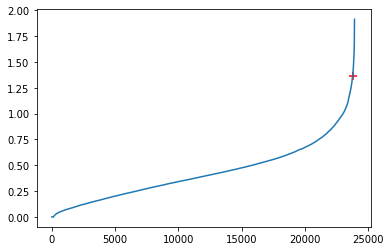

In [181]:
eps_assess(d_norm, 9)

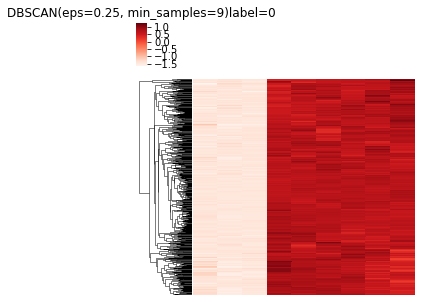

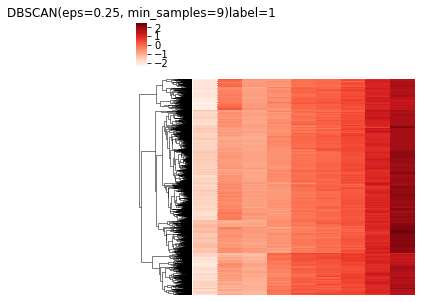

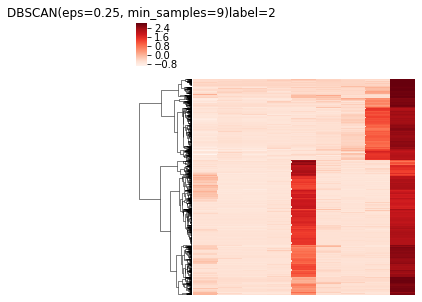

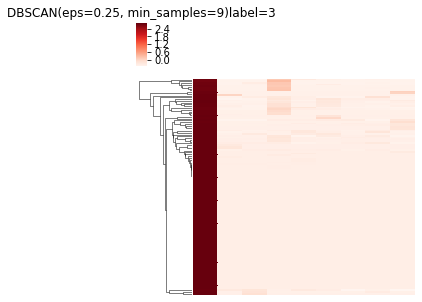

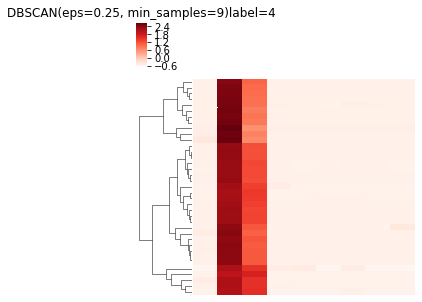

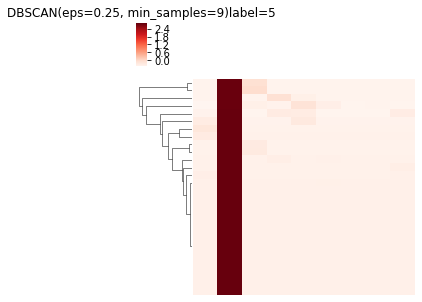

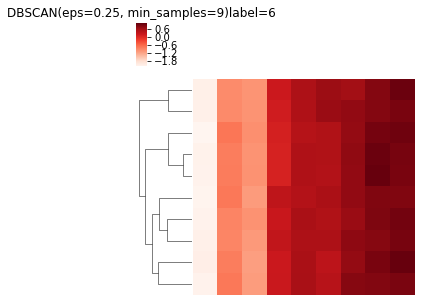

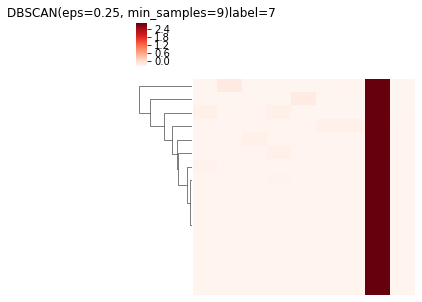

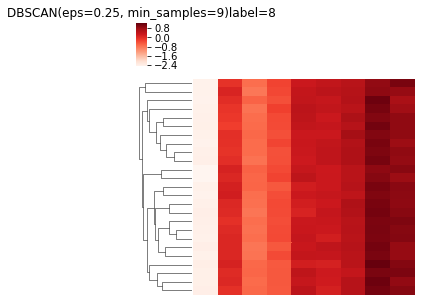

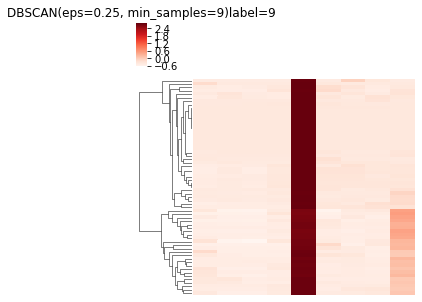

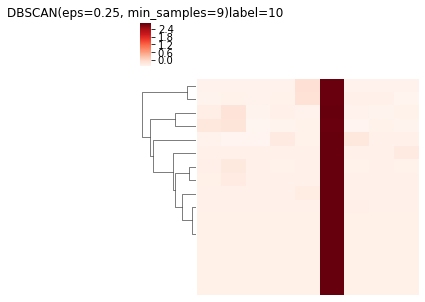

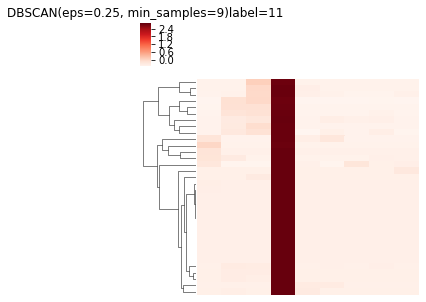

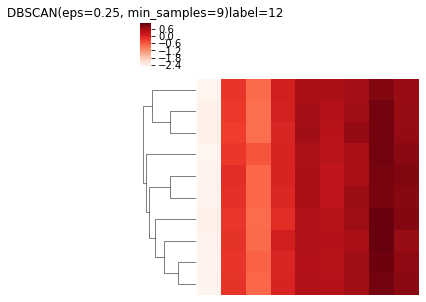

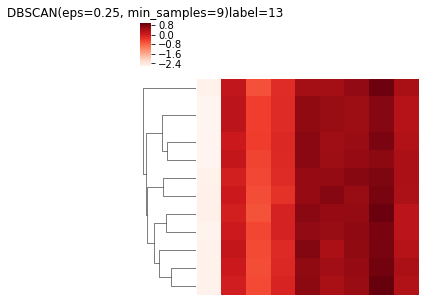

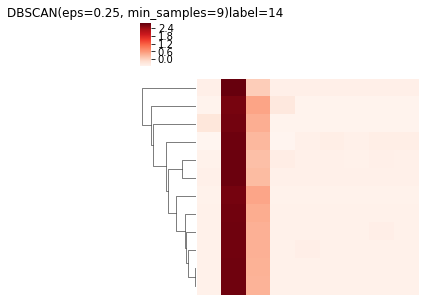

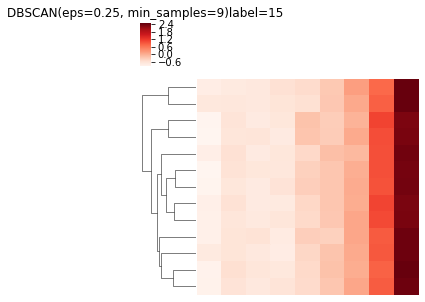

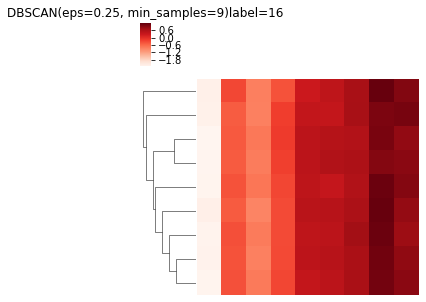

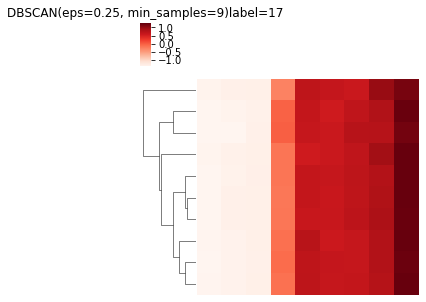

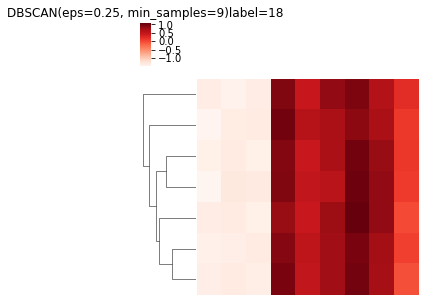

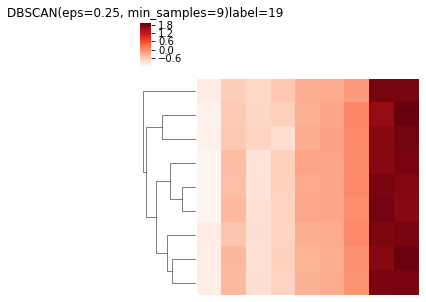

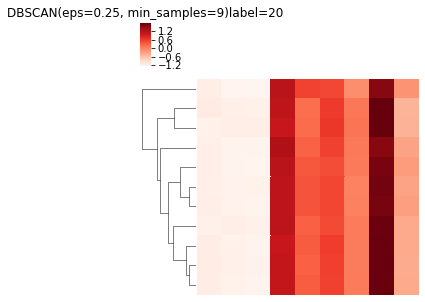

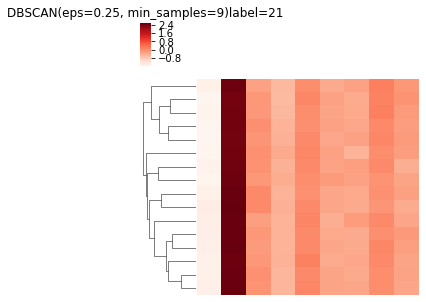

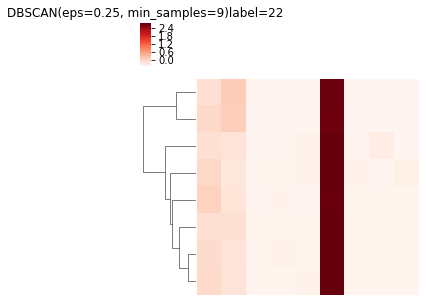

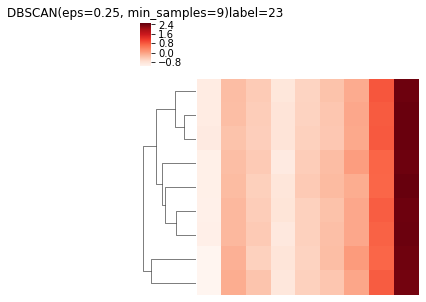

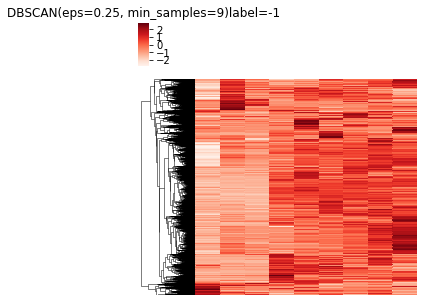

In [184]:
dbscan = cluster.DBSCAN(eps=0.25, min_samples=9).fit(d_norm)
labels = dbscan.labels_
unique_labels = list(set(dbscan.labels_))
for i, k in enumerate(unique_labels):
    indexlist = list(np.argwhere(labels == k).reshape(1, -1)[0])
    sns.clustermap(d_norm.iloc[indexlist].values, cmap='Reds',
                   col_cluster=False, yticklabels=False,
                   xticklabels=False, figsize=(5, 5))
    plt.title(str(dbscan) + 'label=' + str(k))
    plt.show()

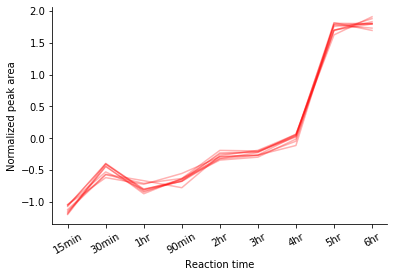

In [190]:
d_plot = d_norm
d_test = d_plot.iloc[np.argwhere(labels == 19).reshape(1,-1)[0]].T
d_test.plot(legend=False,color='red',alpha=0.3)
plt.xticks(rotation=30)
plt.xlabel('Reaction time')
plt.ylabel('Normalized peak area')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)